In [3]:
import abc
import pathlib
import numpy as np
import pandas as pd

data_dir = pathlib.Path('tests').resolve()
calc_dir = data_dir / 'data'
log = calc_dir / 'rasci_1r1h36o_2r13e14o_3r1p6o.casscf_13e14o_ref.ano-yb_r1-i_r0.ybi6_1.gdv_j14p.16262576.log'
fchk = log.with_suffix('.fchk')

archive = log.with_suffix('.h5')

In [4]:
from mctools.basic.basis import MolecularOrbitalBasis, MolecularOrbitalAnsatz
from mctools.ci.states import States

mo = MolecularOrbitalBasis.from_hdf5(archive)
ao = mo.ao_basis

In [5]:
import attrs

@attrs.define(repr=True, eq=True, frozen=True)
class LabelByPartition:
    by: list[str] 
    n_top: int
    save: bool = False
    return_result: bool = True
    
    @property
    def n_by(self) -> int:
        return len(self.by)
    
    def __call__(self, mo: MolecularOrbitalBasis) -> pd.DataFrame | None:
        df = mo.get_partitioning(by=self.by)
        fragments, partorb = df.iloc[:, :self.n_by], df.iloc[:, self.n_by:]
        fragments['label'] = fragments.apply(lambda r: '_'.join(r), axis=1)

        partorb_abs = partorb.apply(np.abs)
        indicies = np.argpartition(partorb_abs, -self.n_top, axis=0)
        labels = fragments['label'].values[indicies[-self.n_top:, :]][::-1, :]
        coeffs = np.take_along_axis(partorb.to_numpy(), indicies[-self.n_top:, :], 0)[::-1, :]

        df_labels = pd.DataFrame(labels.T, columns=[f'label_top{i}' for i in range(1, self.n_top + 1)], dtype='category')
        df_coeffs = pd.DataFrame(coeffs.T, columns=[f'coeff_top{i}' for i in range(1, self.n_top + 1)])
        df_part = pd.concat([pd.concat([df_labels.iloc[:, i], df_coeffs.iloc[:, i]], axis=1) for i in range(self.n_top)], axis=1)
        
        if self.save:
            mo.df = pd.concat([mo.df, df_part], axis=1)
        
        if self.return_result:
            return df_part    

In [206]:
by = ['element', 'L']
df = mo.get_partitioning(by=by)
fragments, partorb = df.iloc[:, :len(by)], df.iloc[:, len(by):]
fragments['label'] = fragments.apply(lambda r: '_'.join(r), axis=1)

In [6]:
labeler = LabelByPartition(by=['element', 'L'], n_top=2, save=True)
labeler(mo)

,label_top1,coeff_top1,label_top2,coeff_top2
0,Yb_S,1.000000+0.000000j,I_P,5.849324e-12+3.648482e- 30j
1,Yb_S,1.000000-0.000000j,I_P,5.849324e-12+1.972152e- 31j
2,I_S,1.000000-0.000000j,I_P,3.625091e-12-8.874685e- 31j
3,I_S,1.000000+0.000000j,I_P,3.625090e-12+1.528418e- 30j
4,I_S,1.000000+0.000000j,I_P,3.621219e-12-2.563798e- 30j
...,...,...,...,...
386,Yb_F,0.999486+0.000000j,I_P,1.731628e-03+7.835055e- 21j
387,Yb_F,0.999486+0.000000j,I_P,1.731628e-03-3.388132e- 21j
388,Yb_F,0.999432+0.000000j,I_P,1.895351e-03+5.293956e- 21j
389,Yb_F,0.999432+0.000000j,I_P,1.895351e-03+2.752857e- 21j


In [7]:
mo.to_hdf5(archive)

/Users/kirill/PycharmProjects/mctools/mctools/newcore/consolidator.py:183: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  self.df.to_hdf(filename, '/'.join([path, name]), format='table')


ValueError: The file '/Users/kirill/PycharmProjects/mctools/tests/data/rasci_1r1h36o_2r13e14o_3r1p6o.casscf_13e14o_ref.ano-yb_r1-i_r0.ybi6_1.gdv_j14p.16262576.h5' is already opened, but in read-only mode.  Please close it before reopening in append mode.

In [215]:
n_top = 1
partorb_abs = partorb.apply(np.abs)
indicies = np.argpartition(partorb_abs, -n_top, axis=0)
labels = fragments['label'].values[indicies[-n_top:, :]][::-1, :]
coeffs = np.take_along_axis(partorb.to_numpy(), indicies[-n_top:, :], 0)[::-1, :]

df_labels = pd.DataFrame(labels.T, columns=[f'label_top{i}' for i in range(1, len(by) + 1)])
df_coeffs = pd.DataFrame(coeffs.T, columns=[f'coeff_top{i}' for i in range(1, len(by) + 1)])
df_part = pd.concat([df_labels, df_coeffs], axis=1)

ValueError: Shape of passed values is (391, 1), indices imply (391, 2)

In [219]:
labels.T.shape

(391, 1)

In [246]:
mo.df['label_top1']

,label_top1,label_top1
0,Yb_S,Yb_S
1,Yb_S,Yb_S
2,I_S,I_S
3,I_S,I_S
4,I_S,I_S
...,...,...
421,NaN,NaN
422,NaN,NaN
423,NaN,NaN
424,NaN,NaN


In [156]:
max_fragment_idx.shape

(391,)

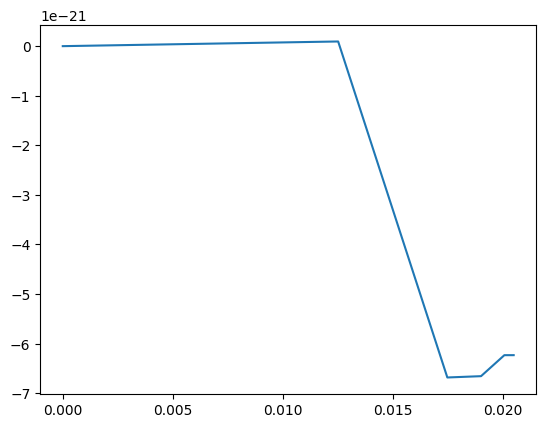

In [37]:
import matplotlib.pyplot as plt

mo_idx = 'MO365'
orb = partorb[['element', 'L', mo_idx]].copy()

orb['norm'] = np.abs(orb[mo_idx])
orb.sort_values('norm', ascending=False, inplace=True)
orb[['X', 'Y']] = np.full((len(orb), 2), 0.)
orb.iloc[1:, 4] = np.cumsum(np.real(orb.iloc[1:, 2]))
orb.iloc[1:, 5] = np.cumsum(np.imag(orb.iloc[1:, 2]))

plt.plot('X', 'Y', data=orb)
plt.show()
plt.close()

In [43]:
np.abs(np.imag(partorb.iloc[:, 2:])).max()

4.336808689942018e-18

In [35]:
partorb

,element,L,MO1,MO2,MO3,MO4,MO5,MO6,MO7,MO8,...,MO382,MO383,MO384,MO385,MO386,MO387,MO388,MO389,MO390,MO391
0,I,S,3.384951e-15+5.175937e- 34j,3.384951e-15+9.148167e- 34j,1.000000e+00-1.336688e- 28j,1.000000e+00+2.016464e- 28j,1.000000e+00+2.380758e- 29j,1.000000e+00-3.678064e- 29j,1.000000e+00-1.307537e- 28j,1.000000e+00-1.064962e- 29j,...,1.646860e-04-4.632211e- 23j,1.855283e-04+1.290402e- 22j,1.855283e-04-1.720536e- 22j,6.816279e-06+1.654361e- 24j,6.816279e-06+4.135903e- 24j,1.107604e-04+1.323489e- 23j,1.107604e-04+2.646978e- 23j,1.373554e-04-3.308722e- 23j,1.373554e-04-1.323489e- 23j,2.827683e-04+7.279189e- 23j
1,I,P,5.849324e-12+3.648482e- 30j,5.849324e-12+1.972152e- 31j,3.625091e-12-8.874685e- 31j,3.625090e-12+1.528418e- 30j,3.621219e-12-2.563798e- 30j,3.621217e-12-4.141520e- 30j,3.645822e-12+3.204747e- 30j,3.645822e-12+1.183291e- 30j,...,2.696718e-03+2.117582e- 21j,2.867007e-03-1.998468e- 21j,2.867007e-03+4.446923e- 21j,5.214804e-04-1.270549e- 21j,5.214804e-04+6.352747e- 22j,1.731628e-03+7.835055e- 21j,1.731628e-03-3.388132e- 21j,1.895351e-03+5.293956e- 21j,1.895351e-03+2.752857e- 21j,2.732727e-03-1.132907e- 20j
2,I,D,2.589484e-15+3.129636e- 34j,2.589484e-15-6.018531e- 35j,1.354575e-15+1.203706e- 34j,1.354576e-15-1.444447e- 34j,1.353331e-15+2.949080e- 34j,1.353331e-15+1.203706e- 35j,1.357607e-15+4.333342e- 34j,1.357607e-15+7.222237e- 35j,...,7.844493e-06+1.292470e- 26j,8.297457e-06-2.100263e- 26j,8.297457e-06+1.454028e- 26j,2.003732e-06+4.846761e- 27j,2.003732e-06-3.917799e- 26j,6.357177e-06+4.846761e- 26j,6.357177e-06+1.292470e- 26j,6.991682e-06-1.130911e- 25j,6.991682e-06+6.462349e- 26j,1.164294e-05-6.462349e- 27j
3,Yb,S,1.000000e+00+3.902396e- 29j,1.000000e+00-4.166172e- 29j,5.553231e-14+0.000000e+ 00j,5.553219e-14-1.694818e- 32j,5.515337e-14-3.543711e- 32j,5.515325e-14-3.081488e- 33j,5.529647e-14+4.622232e- 33j,5.529647e-14-9.244464e- 33j,...,4.140943e-07+1.033976e- 24j,1.228739e-08+0.000000e+ 00j,1.228739e-08+0.000000e+ 00j,3.300168e-07+2.067952e- 25j,3.300168e-07+0.000000e+ 00j,5.006560e-07+0.000000e+ 00j,5.006560e-07+0.000000e+ 00j,1.647009e-09+0.000000e+ 00j,1.647009e-09-1.292470e- 26j,5.068845e-09+0.000000e+ 00j
4,Yb,P,2.272947e-17+1.805559e- 35j,2.272946e-17-3.912045e- 35j,3.023713e-13-3.759415e- 31j,3.023714e-13+1.078521e- 31j,3.016969e-13+8.011869e- 32j,3.016969e-13+9.244464e- 32j,3.097693e-13+9.860761e- 32j,3.097693e-13-3.389637e- 32j,...,5.534768e-05+1.809458e- 25j,5.922282e-05-2.520316e- 25j,5.922282e-05-3.231174e- 25j,1.105014e-06-2.564745e- 26j,1.105014e-06+3.301856e- 26j,1.402676e-05-8.982664e- 25j,1.402676e-05+8.401053e- 26j,1.899239e-05-4.045430e- 24j,1.899239e-05+4.536569e- 24j,5.362590e-05+7.005186e- 24j
5,Yb,D,1.620597e-16+0.000000e+ 00j,1.620597e-16+1.880791e- 36j,4.734095e-14-2.900932e- 33j,4.734100e-14+1.540744e- 33j,4.731597e-14-4.622232e- 33j,4.731602e-14+3.851860e- 33j,4.901534e-14-7.703720e- 33j,4.901534e-14+1.540744e- 33j,...,1.995279e-07+1.615587e- 27j,1.419574e-06+0.000000e+ 00j,1.419574e-06+6.462349e- 27j,8.956478e-08+1.514613e- 28j,8.956478e-08+0.000000e+ 00j,5.704843e-07+0.000000e+ 00j,5.704843e-07-4.038968e- 28j,6.381604e-07+0.000000e+ 00j,6.381604e-07-3.635071e- 27j,1.071831e-06-2.322407e- 27j
6,Yb,F,2.675761e-16+0.000000e+ 00j,2.675761e-16-3.009266e- 36j,6.763285e-15+7.703720e- 34j,6.763282e-15+0.000000e+ 00j,6.720381e-15+0.000000e+ 00j,6.720377e-15+7.703720e- 34j,6.976199e-15+0.000000e+ 00j,6.976199e-15+1.155558e- 33j,...,9.988031e-01+4.235165e- 22j,9.987198e-01-8.470329e- 22j,9.987198e-01+0.000000e+ 00j,9.998517e-01-9.926167e- 24j,9.998517e-01+0.000000e+ 00j,9.994862e-01+7.940934e- 23j,9.994862e-01+6.617445e- 24j,9.994315e-01+8.470329e- 22j,9.994315e-01+0.000000e+ 00j,9.992044e-01+2.977850e- 23j


,element,L,MO1
0,I,S,3.384951e-15+5.175937e- 34j
1,I,P,5.849324e-12+3.648482e- 30j
2,I,D,2.589484e-15+3.129636e- 34j
3,Yb,S,1.000000e+00+3.902396e- 29j
4,Yb,P,2.272947e-17+1.805559e- 35j
5,Yb,D,1.620597e-16+0.000000e+ 00j
6,Yb,F,2.675761e-16+0.000000e+ 00j


In [32]:
by = ['element', 'L']
fragments = ao.df[by].drop_duplicates().reset_index(drop=True)

F = []
f = []
for i, fragment in fragments.iterrows():
    p = np.full(ao.n_ao, True, dtype=np.bool_)
    for col, value in fragment.items():
        p &= ao.df[col] == value
    f.append(p)
    F.append(np.outer(p, p))
f = np.stack(f)
F = np.stack(F)

In [33]:
P = mo.get_density()
S = mo.get_metric()
pop = np.einsum('Att,tt->A', F, P @ S, optimize='optimal')
fragments['pop'] = pop

In [34]:
C = mo.molorb
S = mo.get_metric()

In [35]:
from mctools.core.utils.constants import I2
Ip2 = np.einsum('pat,Ftv,tv,ab,pbv->Fp', C, F, S, I2, C.conj(), optimize='optimal')

In [52]:
frag_idx = (partorb.iloc[:, 2:].abs() ** 2).idxmax(axis=0)
frag_idx.T

MO1      3
MO2      3
MO3      0
MO4      0
MO5      0
        ..
MO387    6
MO388    6
MO389    6
MO390    6
MO391    6
Length: 391, dtype: int64

In [8]:
dfmo = mo.df.copy()

In [19]:
labels = fragments[by].apply(lambda r: '_'.join(r[by]), axis=1)
df1 = pd.DataFrame(Ip2.T, columns=labels)

In [20]:
pd.concat([dfmo, df1], axis=1)

,occupied,resource_idx,I_S,I_P,I_D,Yb_S,Yb_P,Yb_D,Yb_F
0,True,0,3.384951e-15+7.595386e- 33j,5.849324e-12-2.958228e- 31j,2.589484e-15+3.629174e- 33j,1.000000e+00-2.108512e- 22j,2.272947e-17-1.324077e- 34j,1.620597e-16+1.000581e- 34j,2.675761e-16+2.407412e- 35j
1,True,1,3.384951e-15-6.909274e- 33j,5.849324e-12+3.895001e- 30j,2.589484e-15-5.657419e- 34j,1.000000e+00+2.108512e- 22j,2.272946e-17-2.106486e- 35j,1.620597e-16-1.429401e- 35j,2.675761e-16-3.009266e- 35j
2,True,2,1.000000e+00-7.496771e- 24j,3.625091e-12+2.711709e- 30j,1.354575e-15+9.148167e- 34j,5.553231e-14-4.067564e- 31j,3.023713e-13-1.417484e- 31j,4.734095e-14-9.075945e- 32j,6.763285e-15-1.194077e- 32j
3,True,3,1.000000e+00+7.451664e- 24j,3.625090e-12+6.360191e- 30j,1.354576e-15-6.018531e- 34j,5.553219e-14+3.697785e- 31j,3.023714e-13-3.697785e- 32j,4.734100e-14+3.620748e- 32j,6.763282e-15+7.703720e- 33j
4,True,4,1.000000e+00+1.449445e- 24j,3.621219e-12-8.283040e- 30j,1.353331e-15+8.185202e- 34j,5.515337e-14+1.972152e- 31j,3.016969e-13-7.950239e- 31j,4.731597e-14-1.540744e- 32j,6.720381e-15+6.162976e- 33j
...,...,...,...,...,...,...,...,...,...
421,False,421,1.313954e-02-1.482308e- 20j,2.019810e-02+5.421011e- 20j,2.602229e-04+1.526148e- 22j,1.171841e-04+0.000000e+ 00j,1.651896e-02+1.340756e- 21j,1.139839e-06-1.121217e- 24j,1.012586e+00-6.268044e- 19j
422,False,422,1.380578e-02-4.102816e- 21j,2.135368e-02-6.606857e- 20j,2.800468e-04-3.629255e- 23j,1.284640e-06-9.926167e- 24j,1.697738e-02+2.909711e- 21j,2.901400e-06+8.207183e- 25j,1.013627e+00-2.995109e- 18j
423,False,423,1.380578e-02+1.016440e- 20j,2.135368e-02+4.743385e- 20j,2.800468e-04+3.699048e- 23j,1.284640e-06+9.926167e- 24j,1.697738e-02-2.892237e- 21j,2.901400e-06-8.336430e- 25j,1.013627e+00+2.981556e- 18j
424,False,424,1.731698e-02+2.625802e- 20j,2.569220e-02+2.032879e- 20j,3.277309e-04-1.785676e- 22j,3.381545e-07-9.926167e- 24j,2.159196e-02-1.431022e- 21j,2.741812e-06+1.143836e- 24j,1.015991e+00+4.218224e- 18j


In [8]:
Ip2 = pd.DataFrame(Ip2, columns=[f'MO{p}' for p in range(1, Ip2.shape[-1] + 1)])

NameError: name 'Ip2' is not defined

In [116]:
C_inv = np.einsum('pat,tt,ab,pbt->pt', C, S, I2, C.conj(), optimize='optimal')
Ip3 = np.einsum('ft,pt->fp', f, C_inv, optimize='optimal')

In [127]:
pd.concat([fragments, Ip2], axis=1)

,element,l,MO1,MO2,MO3,MO4,MO5,MO6,MO7,MO8,...,MO417,MO418,MO419,MO420,MO421,MO422,MO423,MO424,MO425,MO426
0,I,0,3.384951e-15+7.595386e- 33j,3.384951e-15-6.909274e- 33j,1.000000e+00-7.496771e- 24j,1.000000e+00+7.451664e- 24j,1.000000e+00+1.449445e- 24j,1.000000e+00-1.355231e- 20j,1.000000e+00-1.355894e- 20j,1.000000e+00+1.356556e- 20j,...,4.570007e-03+1.058791e- 21j,4.570007e-03-2.541099e- 21j,1.129820e-04+1.290402e- 22j,1.129820e-04-1.191140e- 22j,0.013140+0.000000j,0.013140-0.000000j,0.013806-0.000000j,0.013806+0.000000j,1.731698e-02+2.625802e- 20j,1.731698e-02-3.176374e- 20j
1,I,1,5.849324e-12-2.958228e- 31j,5.849324e-12+3.895001e- 30j,3.625091e-12+2.711709e- 30j,3.625090e-12+6.360191e- 30j,3.621219e-12-8.283040e- 30j,3.621217e-12-5.916457e- 30j,3.645822e-12-3.254051e- 30j,3.645822e-12-1.262177e- 29j,...,9.646433e-03-4.743385e- 20j,9.646433e-03+2.541099e- 20j,2.255275e-03+8.470329e- 22j,2.255275e-03+4.446923e- 21j,0.020198-0.000000j,0.020198+0.000000j,0.021354-0.000000j,0.021354+0.000000j,2.569220e-02+2.032879e- 20j,2.569220e-02-1.431486e- 19j
2,I,2,2.589484e-15+3.629174e- 33j,2.589484e-15-5.657419e- 34j,1.354575e-15+9.148167e- 34j,1.354576e-15-6.018531e- 34j,1.353331e-15+8.185202e- 34j,1.353331e-15+6.018531e- 35j,1.357607e-15+7.944461e- 34j,1.357607e-15+7.222237e- 35j,...,1.378991e-04+8.106370e- 23j,1.378991e-04-8.023652e- 23j,4.430510e-05-2.820169e- 23j,4.430510e-05+2.729696e- 23j,0.000260-0.000000j,0.000260+0.000000j,0.000280-0.000000j,0.000280+0.000000j,3.277309e-04-1.785676e- 22j,3.277309e-04+1.766031e- 22j
3,Yb,0,1.000000e+00-2.108512e- 22j,1.000000e+00+2.108512e- 22j,5.553231e-14-4.067564e- 31j,5.553219e-14+3.697785e- 31j,5.515337e-14+1.972152e- 31j,5.515325e-14+2.095412e- 31j,5.529647e-14-2.095412e- 31j,5.529647e-14+0.000000e+ 00j,...,3.575627e-04+2.541099e- 21j,3.575627e-04-2.435220e- 21j,1.241591e-04+0.000000e+ 00j,1.241591e-04+0.000000e+ 00j,0.000117+0.000000j,0.000117+0.000000j,0.000001-0.000000j,0.000001+0.000000j,3.381545e-07-9.926167e- 24j,3.381545e-07+9.926167e- 24j
4,Yb,1,2.272947e-17-1.324077e- 34j,2.272946e-17-2.106486e- 35j,3.023713e-13-1.417484e- 31j,3.023714e-13-3.697785e- 32j,3.016969e-13-7.950239e- 31j,3.016969e-13+6.779273e- 31j,3.097693e-13+9.860761e- 32j,3.097693e-13+3.482081e- 31j,...,5.522034e-03+3.578952e- 21j,5.522034e-03-3.603406e- 21j,1.254307e-05-5.210269e- 26j,1.254307e-05+2.071990e- 25j,0.016519-0.000000j,0.016519+0.000000j,0.016977+0.000000j,0.016977-0.000000j,2.159196e-02-1.431022e- 21j,2.159196e-02+1.403519e- 21j
5,Yb,2,1.620597e-16+1.000581e- 34j,1.620597e-16-1.429401e- 35j,4.734095e-14-9.075945e- 32j,4.734100e-14+3.620748e- 32j,4.731597e-14-1.540744e- 32j,4.731602e-14+3.081488e- 33j,4.901534e-14+1.540744e- 33j,4.901534e-14-7.703720e- 33j,...,3.655128e-07+1.203612e- 25j,3.655128e-07-1.163223e- 25j,2.837668e-07+1.777146e- 26j,2.837668e-07-1.777146e- 26j,0.000001+0.000000j,0.000001-0.000000j,0.000003+0.000000j,0.000003-0.000000j,2.741812e-06+1.143836e- 24j,2.741812e-06-1.143836e- 24j
6,Yb,3,2.675761e-16+2.407412e- 35j,2.675761e-16-3.009266e- 35j,6.763285e-15-1.194077e- 32j,6.763282e-15+7.703720e- 33j,6.720381e-15+6.162976e- 33j,6.720377e-15-6.162976e- 33j,6.976199e-15-6.162976e- 33j,6.976199e-15+1.925930e- 33j,...,1.006344e+00+1.768605e- 18j,1.006344e+00-1.792322e- 18j,1.001817e+00-3.049319e- 20j,1.001817e+00+3.049319e- 20j,1.012586+0.000000j,1.012586-0.000000j,1.013627-0.000000j,1.013627+0.000000j,1.015991e+00+4.218224e- 18j,1.015991e+00-4.218224e- 18j


In [79]:
path, info = np.einsum_path('pat,Ftv,tv,ab,pbv->Fp', C, F, S, I2, C.conj(), optimize='optimal')
print(info)

  Complete contraction:  pat,Ftv,tv,ab,pbv->Fp
         Naive scaling:  6
     Optimized scaling:  5
      Naive FLOP count:  2.706e+09
  Optimized FLOP count:  8.128e+08
   Theoretical speedup:  3.329
  Largest intermediate:  3.176e+05 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   4                 ab,pat->btp                       Ftv,tv,pbv,btp->Fp
   3                 tv,Ftv->Ftv                          pbv,btp,Ftv->Fp
   5             Ftv,btp,pbv->Fp                                   Fp->Fp


In [76]:
np.array_equal(Ip1, Ip2)

False

In [54]:
from rich import inspect
import h5py

inspect(h5py.File)

╭───────────────────────────────────────── <class 'h5py._hl.files.File'> ─────────────────────────────────────────╮
│ class File(name, mode='r', driver=None, libver=None, userblock_size=None, swmr=False, rdcc_nslots=None,         │
│ rdcc_nbytes=None, rdcc_w0=None, track_order=None, fs_strategy=None, fs_persist=False, fs_threshold=1,           │
│ fs_page_size=None, page_buf_size=None, min_meta_keep=0, min_raw_keep=0, locking=None, alignment_threshold=1,    │
│ alignment_interval=1, meta_block_size=None, **kwds):                                                            │
│                                                                                                                 │
│ Represents an HDF5 file.                                                                                        │
│                                                                                                                 │
│           attrs = <property object at 0x118dbfce0>                                                              │
│          driver = <property object at 0x119121fd0>                                                              │
│            file = <property object at 0x118dbf2e0>                                                              │
│        filename = <property object at 0x118dbfdd0>                                                              │
│              id = <property object at 0x118dbf790>                                                              │
│          libver = <property object at 0x119122020>                                                              │
│ meta_block_size = <property object at 0x1191220c0>                                                              │
│            mode = <property object at 0x119121f80>                                                              │
│            name = <property object at 0x118dbf380>                                                              │
│          parent = <property object at 0x118dbf4c0>                                                              │
│             ref = <property object at 0x118dbf7e0>                                                              │
│       regionref = <property object at 0x118dbf830>                                                              │
│       swmr_mode = <property object at 0x1191221b0>                                                              │
│  userblock_size = <property object at 0x119122070>                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [7]:
|k = list(data[-1][Link.L302].keys())[0]

SyntaxError: invalid syntax (1561671745.py, line 1)

In [8]:
array = data[-1][Link.L302][Resources.ao_int1e_overlap]

NameError: name 'data' is not defined

In [ ]:
dim = 575

tril = np.tril_indices(575)
matrix = np.zeros((dim, dim))
matrix[tril] = array

In [9]:
m1 = (matrix + matrix.T - matrix.diagonal()).copy()
m2 = matrix.copy()

m2 += m2.T - m2.diagonal()

NameError: name 'matrix' is not defined

In [10]:
import numpy as np
from mctools.parsing.core import ProcessedPattern

def process_data_type(char: str, /):
    match char:
        case 'R':
            return np.float_
        case 'I':
            return np.int_
        case 'C':
            return np.str_
        case _:
            raise ValueError(f'Invalid data_type: {char}')
        
FCHK_HEADER_PATT = ProcessedPattern(
    r'(?P<header>([A-Z][a-zA-Z]+)(\s[a-zA-Z]+)+)\s+'
    r'(?P<dtype>[IRCHL])\s+'
    r'((N=\s+(?P<size>\d+))|(?P<value>[+-]?\d+(\.\d+[dDeE]\+\d+)?))',
    constructor='header',
    group_maps={
        'size': lambda s: int(s) if s else s,
        'dtype': process_data_type,
    },
    match_funcs={
        'value': lambda m: (int(m.pop('value')) if m['size'] else m['dtype'](m.pop('value'))) if m['value'] else None
    }
)

scalar1 = 'Number of electrons                        I              391'
scalar2 = 'SCF Energy                                 R     -5.674493527405919E+04'
array = 'Nuclear charges                            R   N=           7'
headers = [scalar1, scalar2, array]


for h in headers:
    print(h)
    if match := FCHK_HEADER_PATT.match(h):
        print(match)

Number of electrons                        I              391
header(header='Number of electrons', dtype=<class 'numpy.int64'>, size=None, value=391)
SCF Energy                                 R     -5.674493527405919E+04
header(header='SCF Energy', dtype=<class 'numpy.float64'>, size=None, value=-56744.93527405919)
Nuclear charges                            R   N=           7


ValueError: invalid literal for int() with base 10: 'None'

In [ ]:
|int('')

In [11]:
from typing import IO, AnyStr, Any

from mctools.parsing.gaussian.log.l1 import Link, Route
from mctools.parsing.core import BaseFileParser, ListeningFileParser, FileParser


class LinkParser(FileParser, metaclass=abc.ABCMeta):
    pass




ModuleNotFoundError: No module named 'mctools.parsing.gaussian.log.l1'

In [12]:
from mctools.parsing.gaussian.log.l1 import Link
f'{Link.L910}'

ModuleNotFoundError: No module named 'mctools.parsing.gaussian.log.l1'

In [13]:
from mctools.parsing.gaussian import LogParser

parser = LogParser()
data = parser.parser(log, int1e=['stv'])

AttributeError: 'LogParser' object has no attribute 'parser'

In [14]:
from mctools.parsing.gaussian import FchkParser

with fchk.open('r', encoding='ascii') as f:
    parser = FchkParser()
    data = parser.parse(f)

basis_info = data[FchkParser.options_cls.basis]
basis = basis_info['basis']
shells = basis_info['shells']
prims = basis_info['prims']
aos = basis.df.copy()

n_inactive = 342
n_active = 50
molorb = data[FchkParser.options_cls.molecular_orbitals]
active_space = np.s_[n_inactive:n_inactive + n_active]
actorb = molorb[active_space]
# mos = basis.partition_molorb(actorb, by=['element', 'l']) 

atom_idx, shell_idx = 0, 0

─ Fchk file: /Users/kirill/PycharmProjects/mctools/tests/data/rasci_1r1h36o_2r13e14o_3r1p6o.casscf_13e14o_ref.an… ─

Parsing FCHK description...

Parsing Molecule geometry...

Parsing Atomic Orbital Basis...

Parsing Molecular Orbital Basis...

Finished parsing FCHK file

AttributeError: type object 'FchkParser' has no attribute 'options_cls'

In [ ]:
prims

In [ ]:
import pathlib
import time
import numpy as np

from tqdm import tqdm

from mctools.parsing import FileStepper
from mctools.parsing.gaussian.log.utils import MatrixParserMixin


data_dir = pathlib.Path('examples').resolve()
calc_dir = data_dir / 'calc'

fchk =  calc_dir / 'casscf.fchk'
log = fchk.with_suffix('.log')

line_to_data = lambda l: l.strip().replace('D', 'E').split()


def read_wrapped_matrix(stepper: FileStepper, header: str, dtype=float):
    stepper.step_skip_until(header) 
    
    is_data_row = lambda l: '.' in l
    is_header_row = lambda l: not is_data_row(l)
    
    array = []
    dim_size = 0
    n_cols_per_blocks = len(stepper.readline().strip().split())
    
    while '.' in (line := stepper.readline()):
        row = line.strip().replace('D', 'E').split()
        array.extend(map(float, row[1:]))
        dim_size += 1

    n_elems = (dim_size * dim_size - dim_size) // 2  + dim_size 
    for j in range(n_cols_per_blocks, dim_size, n_cols_per_blocks):
        for i in range(j, dim_size):
            row = stepper.readline().strip().replace('D', 'E').split()
            array.extend(map(dtype, row[1:]))
        
        if len(array) < n_elems:
            stepper.readline()
        else:
            break
    return array

# header = 'Overlap'
# dim = 575


n_states = 50

n_mo_act = 50
rdm_shape = (n_mo_act, n_mo_act)
header_real = '1PDM Matrix (real) :'
header_imag = '1PDM Matrix (imag) :'

array = []

times = []
with log.open('r') as f:
    parser = MatrixParserMixin()
    parser.set_file(f)

    for i in tqdm(range(n_states)):
        parser.step_skip_until(header_real) 
        
        t0 = time.perf_counter_ns()
        parser.read_rectangular(*rdm_shape, array=array)
        t1 = time.perf_counter_ns()
        times.append(t1 - t0)
        
        parser.step_skip_until(header_imag) 
        
        t0 = time.perf_counter_ns()
        parser.read_rectangular(*rdm_shape, array=array)
        t1 = time.perf_counter_ns()
        times.append(t1 - t0)

times = np.asarray(times)
print(times.mean(), times.std())

In [ ]:
rdms_32 = np.asarray(array, dtype=np.float32).reshape((n_states, 2, n_mo_act, n_mo_act))
rdms_32 = np.moveaxis(rdms_32, 1, -1, ).copy()
rdms_32 = rdms_32.view(np.complex64).squeeze()

In [15]:
rdms_64 = np.asarray(array, dtype=np.float64).reshape((n_states, 2, n_mo_act, n_mo_act))
rdms_64 = np.moveaxis(rdms_64, 1, -1, ).copy()
rdms_64 = rdms_64.view(np.complex128).squeeze()

ValueError: could not convert string to float: 'Nuclear charges                            R   N=           7'

In [16]:
import re
 CI Transition Density Matrix     1 :     3
 Compute 1PDM now
 1TDM Matrix:                       1
header = 'Oscillator Strength For States      1 :      2 f=    0.000000'
header = 'Computing Spin expectation values.'
l = 'State:           1  <Sx>=  0.1340 <Sy>=  0.0000 <Sz>=  0.0823 <Sx**2>=  0.2623 <Sy**2>=  0.2623 <Sz**2>=  0.2624 <S**2>=  0.7870 S=  0.5183'

IndentationError: unexpected indent (851130380.py, line 2)

 Computing Spin expectation values.

 Computing Spin expectation values.
 State:           1  <Sx>=  0.1340 <Sy>=  0.0000 <Sz>=  0.0823 <Sx**2>=  0.2623 <Sy**2>=  0.2623 <Sz**2>=  0.2624 <S**2>=  0.7870 S=  0.5183
 
 Using Dipole Ints in file:                     872
 CI Transition Density Matrix     1 :     2
 Compute 1PDM now
 1TDM Matrix:                       1
 1TDM Matrix:                       2
 Oscillator Strength For States      1 :      2 f=    0.000000

In [17]:
%timeit list(map(float, l.split()[1::2][1:]))

NameError: name 'l' is not defined

In [ ]:
%timeit list(map(float, re.findall('\d+\.\d+', l)))

In [ ]:
3.28 * 1e3 / 858

In [18]:
from mctools.parsing.gaussian.log.l302 import read_ao_overlap_matrix

n_checks = 10
times = np.zeros(n_checks)
for k in range(n_checks):
    with log.open('r') as f:

        t0 = time.perf_counter_ns()
        array = read_ao_overlap_matrix(f, first_line='')
        t1 = time.perf_counter_ns()
    
        times[k] = t1 - t0

print(times.mean() / 1e6, times.std() / 1e6) 

ModuleNotFoundError: No module named 'mctools.parsing.gaussian.log.l302'

In [19]:
f = np.vectorize(lambda v: f'{v:e}')

strings = f(np.random.uniform(-1e-8, 1e8, 5000))
strings_lst = list(np.char.replace(strings, 'e', 'D'))

In [ ]:
%timeit np.char.replace(strings, 'D', 'e').astype(np.float_)

In [ ]:
%timeit np.fromiter(map(lambda v: v.replace('D', 'e'), strings_lst), dtype=np.float_)

In [ ]:
dim_size

In [ ]:
import numpy as np

arr64 = np.asarray(array, dtype=np.float64)
arr32 = np.asarray(array, dtype=np.float32)

In [ ]:
arr64.nbytes / 1024

In [ ]:
arr32.nbytes / 1024

# Analyze CAS States

In [ ]:
from mctools.parser.gaussian import parse_gdvlog, l302_parser_funcs_general, l302_postprocess_general, l910_parser_funcs_fast

gdvlog = data_dir / 'casscf.log'

data = parse_gdvlog(
    gdvlog, 
    l302_parser_funcs_general | l910_parser_funcs_fast,
    postprocess_links=l302_postprocess_general
)

In [ ]:
import mmap
import re

from collections import defaultdict
from typing import Callable, IO, AnyStr, Any

general_link_patt = re.compile(rb'^\s+((\(Enter|Entering Link)[\s\d=]+(?P<path>\/.*\.[\w:]+))', flags=re.MULTILINE)


def parse_general_link_path(path: str) -> str:
    return pathlib.Path(path).stem

def find_links_re(filename: str | pathlib.Path, *, parse_link_path: Callable[[str], str] | None = None) ->  dict[str, list[tuple[int, int | None]]]:
    parse_link_path = parse_general_link_path if parse_link_path is None else parse_link_path

    filesize: int
    found_links: list[tuple[str, int]] = []
    with pathlib.Path(filename).open(mode="r", encoding="ascii") as file_obj:
        with mmap.mmap(file_obj.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_obj:
            filesize = int(mmap_obj.size())
            for match in general_link_patt.finditer(mmap_obj):
                link = parse_link_path(match.groupdict()['path'].decode())
                start = match.span(0)[0]
                found_links.append((link, start))
    
    links: dict[str, list[tuple[int, int | None]]] = defaultdict(list)
    for i, (path, start) in enumerate(found_links[:-1]):
        next_start = found_links[i + 1][1]
        links[path].append((start, next_start - start))
    else:
        path, start = found_links[-1]
        links[path].append((start, filesize - start))
        
    return links


def find_links(filename: str | pathlib.Path, include_l1: bool = False) ->  dict[str, list[tuple[int, int | None]]]:
    filesize = 0
    found_links: list[tuple[str, int]] = []
    with pathlib.Path(filename).open(mode="r", encoding="ascii") as file_obj:
        with mmap.mmap(file_obj.fileno(), length=0, access=mmap.ACCESS_READ) as mmap_obj:
            if include_l1:
                for line in iter(mmap_obj.readline, b""):
                    if line.startswith(b' Entering Link'):
                        link = line.strip().split()[4].rsplit(b'/', 1)[-1].split(b'.')[0].decode()
                        found_links.append((link, filesize))
                        filesize += len(line)
                        break
                    filesize += len(line)
                
            for line in iter(mmap_obj.readline, b""):
                if line.startswith(b' (Enter'):
                    link = line.strip().strip(b'()').rsplit(b'/', 1)[-1].split(b'.')[0].decode()
                    found_links.append((link, filesize))
                filesize += len(line)
    
    links: dict[str, list[tuple[int, int | None]]] = defaultdict(list)
    for i, (link, start) in enumerate(found_links[:-1]):
        next_start = found_links[i + 1][1]
        links[link].append((start, next_start - start))
    else:
        link, start = found_links[-1]
        links[link].append((start, filesize - start))
        
    return links


def parse_link(filename: str | pathlib.Path, offset: int, length: int) -> None:
    mmap_offset = (offset // mmap.ALLOCATIONGRANULARITY) * mmap.ALLOCATIONGRANULARITY
    link_offset = offset - mmap_offset
    mmap_length = link_offset + length
    
    with pathlib.Path(filename).open(mode="r", encoding="ascii") as f:
        with mmap.mmap(f.fileno(), length=mmap_length, access=mmap.ACCESS_READ, offset=mmap_offset) as mmap_obj:
            mmap_obj.seek(link_offset)
            for i, line in enumerate(iter(mmap_obj.readline, b"")):
                print(line.decode("utf-8").strip())

In [ ]:
from mctools.core.mcspace import MCSpace
from mctools.parser.lib import ParsingResult

L910 = 'l910'

rout_patt = re.compile(r'^ *(\d+)\/(\d+=[-\d]+,?)+\/(\d,?)+;')

RouteType =  dict[str, list[dict[int, int]]] 
def parse_l1(filename: str | pathlib.Path) -> RouteType:
    route: RouteType = defaultdict(list)
    with pathlib.Path(filename).open(mode="r") as file_obj:
        for line in file_obj:
            if line.startswith(' Leave'):
                break
                
            if rout_patt.match(line):
                line = line.strip().strip(';')
                start, middle, ends = line.split('/')
                middle = {k: v for k, v in map(lambda p: tuple(map(int, p.split('='))), middle.split(','))}
                ends = [e.rjust(2, '0') for e in ends.split(',')]
                
                for end in ends: 
                    link = 'l' + start + end
                    route[link].append(middle)
    return route

def parse_l910_route(route: RouteType, route_idx: int = 0) -> tuple[bool, ParsingResult]:
    if L910 not in route:
        return False, ParsingResult()
    
    l910_route = route[L910][route_idx]
    
    n_elec = l910_route.get(6, 0)
    n_mos = l910_route.get(7, 0)
    max_hole = l910_route.get(111, 0)
    ras1_mo = l910_route.get(112, 0)
    max_elec = l910_route.get(113, 0)
    ras3_mo = l910_route.get(114, 0)
    ras2_mo = n_mos - ras1_mo - ras3_mo
    mcspace = MCSpace.from_space_spec(
        (ras1_mo, ras2_mo, ras3_mo), n_elec,
        max_hole=max_hole, max_elec=max_elec
    )
    
    n_states = l910_route.get(17, 1)
    n_states = n_states // 10000 + n_states % 10000  # Account for M0000, where M is number higher energy states in Davidson
    
    n_ground = l910_route.get(19, None)
    n_ground = n_states if n_ground and n_ground < 0 else n_ground
    
    has_rdms = l910_route.get(32, 1)
    has_rdms = has_rdms == 0 or has_rdms == 1
    
    has_tdms = bool(l910_route.get(131, 0)),
    
    return True, {
        'mcspace': mcspace,
        'n_states': n_states,
        'n_ground': n_ground,
        
        'has_rdms': has_rdms,
        'has_tdms': has_tdms,
        
        'n_mo_act': lambda _: mcspace.n_mo_act
    }

In [ ]:
result = {}
build_l910_parser_funcs(route, result=result)

In [ ]:
result

In [ ]:
s1 = set((k,len(v)) for k, v in links.items())
s2 = set((k,len(v)) for k, v in route.items())
assert s1 == s2

In [ ]:
cas_space = MCSpace.from_dict(data, max_hole=0, max_elec=0)
cas_states = MCStates.from_dict(data, mcspace=cas_space)

cas_space.set_mo_blocks({
    '4f': [(0, 13), 49],
    '5p': [(13, 49)]
})

cas_space.set_config_classes({
    'f13': {'4f': 13, '5p': 36},
    'Lf14': {'4f': 14, '5p': 35},
})

cas_states.analyze()

In [ ]:
cas_states.print_state(idx=[0, 1])

In [ ]:
from mctools.plot.states import prepare_state_centers

width = 0.1
x_c = prepare_state_centers(cas_states, column_width=2)

plt.hlines('E', x_c - width, x_c + width, data=cas_states.df)
plt.show()

# Analyze RASCI States

In [ ]:
rasci_gs_dir = '/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-36p-14f'

gs_space = MCSpace.from_space_spec(
    (36, 14, 12), 37,
    max_hole=2, max_elec=2,
    mo_blocks={
        '3p': [(0, 36)],
        '4f': [(36, 50)],
        'virt': [(50, 62)],
    },
    config_classes={
        'f1': {'3p': 36, '4f': 1, 'virt': 0},
        'Lf2': {'3p': 35, '4f': 2, 'virt': 0}
    }
)

ce3p_cas_gdvlog = os.path.join(rasci_gs_dir, 'rasci_62s.ce3p_casscf_sa14_14s_gb3lyp_ref.tzvppall.gdv_j14p.7491751.log')
data = parse_gdvlog(ce3p_cas_gdvlog, l910_parser_funcs_general)
states = MCStates.from_dict(data, space=gs_space)
states.analyze()

In [ ]:
ce4p_space = MCSpace.from_space_spec(
    (36, 14, 12), 36,
    max_hole=2, max_elec=2,
    mo_blocks={
        '3p': [(0, 36)],
        '4f': [(36, 50)],
        'virt': [(50, 62)],
    },
    config_classes={
        'f0': {'3p': 36, '4f': 0, 'virt': 0},

        'Lf1': {'3p': 35, '4f': 1, 'virt': 0},
        'Ld1': {'3p': 35, '4f': 0, 'virt': 1},

        'L2f1d1': {'3p': 34, '4f': 1, 'virt': 1},
        'L2f0d2': {'3p': 34, '4f': 0, 'virt': 2},
    }
)

ce4p_cas_gdvlog = os.path.join(rasci_gs_dir, 'rasci_62s.ce4p_gb3lyp_ref.tzvppall.gdv_j14p.7403644.log')
data = parse_gdvlog(ce4p_cas_gdvlog, l910_parser_funcs_general)
ce4p = MCStates.from_dict(data, space=ce4p_space)
ce4p.analyze()

In [ ]:
with pd.option_context('max_colwidth', 100_000, 'display.expand_frame_repr', False):
    df = ce4p.get_state_ci_vec([1])
    print(df)

In [ ]:
ce4p.print_state(idx=[0, 1, 2], include_mo=True, include_config_class=True, shift_ground=True, config_limit=6)

In [ ]:
ce4p.df

#  M-Edge Spectrum

In [ ]:
rasci_gdvlog = os.path.join(data_dir, 'rasci_3.log')

m_edge_data = parse_gdvlog(rasci_gdvlog, l910_parser_funcs_general, n_ground=14)
medge_space = MCSpace.from_dict(m_edge_data, max_hole=1, max_elec=0)
medge_states = MCStates.from_dict(m_edge_data, space=medge_space)


medge_space.mo_blocks = {
    '3d': [(0, 10)],
    '4f': [(10, 23), 59],
    '5p': [(23, 59)],
}

medge_space.config_classes = {
    'f13': {'3d': 10, '4f': 13, '5p': 36},
    'Lf14': {'3d': 10, '4f': 14, '5p': 35},
    'f14': {'3d': 9, '4f': 14, '5p': 36},
}

medge_states.analyze()

In [ ]:
print(medge_states.df)

In [ ]:
print(medge_states.peaks.df)

In [ ]:
gdvlog = '/Users/kirill/Documents/UW/Li_Group/CrI3_Yb/notebooks/../calculations/mc/x2c_tzvpall_2c/cas_36p_14f/rasci/rasci_68s.r1_2s_6p_10d.casscf_sa50_50s_ref.yb3p.exp.tzvpall.gdv_j14p.7748435.log'

data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=14)
medge_space = MCSpace.from_dict(data, max_hole=0, max_elec=0, use_python_int=True)
medge_states = MCStates.from_dict(data, space=medge_space)
medge_spec = MCSpectrum.from_dict(data, states=medge_states)

medge_space.mo_blocks = {
    'M': [(0, 18)],
    '4f':   [(18, 31), 67],
    '5p':   [(31, 67),],

    # 'virt': [(60, 72)],
}

medge_space.config_classes = {
    'f13': {'4f': 13},
    'Lf14': {'5p': 35, '4f': 14},
    'Mf14': {'M': 17, '4f': 14},
}

medge_spec.analyze()

In [ ]:
medge_spec.states.df['state'].isin([1, 2])

# Partitioned K-edge Spectrum

In [ ]:
spec_space = MCSpace.from_space_spec(
    (12, 14, 10), 13,
    max_hole=2, max_elec=1,
    mo_blocks={
        '1s': [(0, 6)],
        '3p': [(6, 12)],
        '4f': [(12, 26)],
        '5d': [(26, 36)],
    },
)

gdvlogs = sorted(glob.glob(os.path.join(data_dir, 'spectrum', 'part*.log')))

spec_parts = []
for gdvlog in gdvlogs:
    part_data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=2)
    spec = MCSpectrum.from_dict(part_data, space=spec_space, sort_peaks=True, )
    spec_parts.append(spec)

In [ ]:
left = spec_parts[0].states
right = spec_parts[1].states

alignment = get_state_alignment(left, right)

In [ ]:
sl_l, sl_r, overlap = alignment[2]

dfl = left.df.iloc[sl_l][left.IDX_COLS].rename(columns={
    left.STATE_COL: f'{left.STATE_COL}_left',
    left.SOURCE_COL: f'{left.SOURCE_COL}_left',
})

dfr = right.df.iloc[sl_r][right.IDX_COLS].rename(columns={
    right.STATE_COL: f'{right.STATE_COL}_right',
    right.SOURCE_COL: f'{right.SOURCE_COL}_right',
})

df = pd.concat([dfl.reset_index(drop=True), dfr.reset_index(drop=True)], axis=1)
df['overlap'] = overlap

In [ ]:
spec = MCSpectrum.from_spectra(spec_parts)

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.vlines('dE', 0, 'osc', data=spec.df)
plt.show()

In [ ]:
spec.df

In [ ]:
rasci_dir = '/Users/kirill/Documents/UW/Li_Group/CsPbCl3_Ln/calculations/rasci/ras-t1u_1s_3p-14_4f-10_5d/dipoles'

gdvlogs = glob.glob(os.path.join(rasci_dir, 'rasci_414s.*ano_cl*.log'))

space = MCSpace.from_space_spec(
    ras=(12, 14, 10),
    elec=13,
    max_hole=2, max_elec=1,
    mo_blocks={
        '1s': [(0, 6)],
        '3p': [(6, 12)],
        '4f': [(12, 26)],
        '5d': [(26, 36)],
    },
)

spec_parts = []
for gdvlog in gdvlogs:
    part_data = parse_gdvlog(gdvlog, l910_parser_funcs, n_ground=14)
    spec = MCSpectrum.from_dict(part_data, space=space, sort_peaks=True)
    spec_parts.append(spec)

spec_parts = sorted(spec_parts, key=lambda x: np.mean(x.energy_range))

In [ ]:
MCSpectrum.from_spectra(spec_parts)